# Case Study 2: Prediction on Diabetes Patients Hospital Readmission

Team Members: 
- Benjamin Goodwin
- Lijju Mathew
- Pradeep Kumar
- Sid Swarupananda



# Business Understanding

#### Problem Statement
- Tracking the number of patients who experience unplanned readmissions to a hospital after a previous hospital stay is one category of data used to evaluate the quality of hospital care. (mayoclinic.org)

- One example of an unplanned readmission would be someone who is readmitted to the hospital for a surgical wound infection that occurred after his or her initial hospital stay. (mayoclinic.org)

- It's important to note that unplanned hospital readmissions may or may not be related to the previous visit, and some unplanned readmissions aren't preventable. Whatever the reason, insurance companies and other payers sometimes view unplanned hospital readmissions as wasteful spending. (mayoclinic.org)

- Mayo Clinic defines hospital readmission as patient admission to a hospital within 30 days after being discharged from an earlier hospital stay. (mayoclininc.org)

- The standard benchmark used by the Centers for Medicare & Medicaid Services (CMS) is the 30-day readmission rate. Rates at the 80th percentile or lower are considered optimal by CMS. (mayoclininc.org)

- In this case study we are trying to predict the factors for hospital readmission in diabetic patients 



#### Libraries and data entry

In [1]:
import os
#os.chdir('C:/Users/sswarupa/OneDrive - GameStop, Inc/Documents/SMU/QTW/Case Studies/CS2/dataset_diabetes')
import sklearn
import sys, copy
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('diabetic_data.txt')

# Data Evaluation/Engineering

#### We will take a look at some data evaluation and engineering here, we will discuss if there are missing values, variables that are needed or unneeded and close out with some assumptions required for the completion of this case study.

In [3]:
#First we will take at look at the data in its original state
df.describe(include='all')


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,...,1,4,4,2,2,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,NaN,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

The Readmitted column has 3 types of values. They are 'NO" , '>30' and '<30' for no readmission, readmitted after 30 days and readmitted within 30 days respectively. Our goal is to predict readmission with in 30 days. Modify the data to binary data to achieve this objective by considering "NO" and ">30" as 0 and "<30" as 1.

In [5]:
target_col ={'NO':0,
             '>30':0,
             '<30':1}

df['readmitted_binary'] = df['readmitted'].map(target_col)



# Missing Value handling

There are 101766 rows of data. Many of the columns have missing values but none of the missing values are in the format of NaN. The missing values are represented with a ? char in the features. 

In [6]:
#Check out the data, start to make some decisions on columns and missing data

#Compute percentages of each columns missing data
percent_missing = df.isnull().values.any().sum()/len(df)  
#Put percents into dfReduced
missing_value_df = pd.DataFrame({'Column name': df.columns,
                                 'Percent_missing': percent_missing})
#Sort it and show the results
missing_value_df.sort_values('Percent_missing', inplace=True)
missing_value_df.round(4)

,Column name,Percent_missing
0,encounter_id,0.0
27,chlorpropamide,0.0
28,glimepiride,0.0
29,acetohexamide,0.0
30,glipizide,0.0
31,glyburide,0.0
32,tolbutamide,0.0
33,pioglitazone,0.0
34,rosiglitazone,0.0
35,acarbose,0.0


In [7]:
df.loc[df['weight']=='?', 'weight'].shape

(98569,)

In [8]:
df.weight.unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

### The Weight column does not have weight in numeric format. When the value is present, it is in string format. Around 96% of the weight column is filled with '?'. Only about 4% of data is valid.

In [9]:
df1 = df.loc[df['weight']=='?', :]

In [10]:
df1.loc[df['admission_source_id']==11].shape[0]

2

In [11]:
df.loc[(df['age']=='[90-100)') & (df['weight']!='?'),'weight'].value_counts()


[50-75)     59
[75-100)    24
[25-50)      9
Name: weight, dtype: int64

### Imputation of weight data. Consider Age as another indicator of weight, lets look at valid weights specific to a age range. Example , in the age range of 10-20, there are 18 valid entries for weight. These 18 entries has only 2 range of weights 25-50 and 50-75. 50-75 weight range is 78% of them. So lets substute all the missing values for age range of 10-20 with weight 50-75. Following this rule, for every age range , the weight range with max count was taken and substituted for missing values.

In [12]:
df.loc[(df['age']=='[10-20)') & (df['weight']=='?'),'weight']='[50-75)'

df.loc[(df['age']=='[0-10)') & (df['weight']=='?'),'weight']='[0-25)'

df.loc[(df['age']=='[20-30)') & (df['weight']=='?'),'weight']='[50-75)'

df.loc[(df['age']=='[30-40)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[40-50)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[50-60)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[60-70)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[70-80)') & (df['weight']=='?'),'weight']='[75-100)'

df.loc[(df['age']=='[80-90)') & (df['weight']=='?'),'weight']='[50-75)'

df.loc[(df['age']=='[90-100)') & (df['weight']=='?'),'weight']='[50-75)'

In [13]:
# The following columns still have missing values.
cols = df.columns

for e in cols:
    c1 = df.loc[df[e]=='?',e]
    if len(c1)>0:
        print('{} {} '.format(e, len(c1)))


race 2273 
payer_code 40256 
medical_specialty 49949 
diag_1 21 
diag_2 358 
diag_3 1423 


In [14]:
df2 = df.loc[df['race']=='?',['age','weight','diabetesMed']]
df2['diabetesMed'].value_counts()
#print(df.loc[df['race']=='?',['race']].shape[0])

Yes    1871
No      402
Name: diabetesMed, dtype: int64

### Imputation of race data. Lets check the distribution of race

Caucasian          58450
AfricanAmerican    14798
Hispanic            1551
Other               1218
Asian                475
Name: race, dtype: int64


<AxesSubplot:>

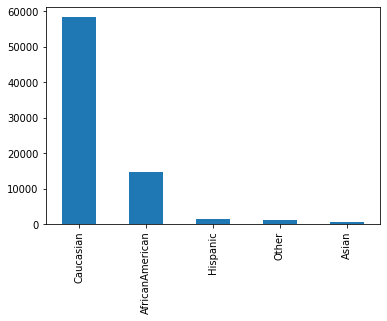

In [15]:
df_race = df.loc[(df['race']!='?') & (df['diabetesMed']=='Yes'),['race','diabetesMed','age']]
by_race = df_race['race'].value_counts()
print(by_race)
by_race.plot.bar()

### Among the 2273 missing race, 1871 (82%) have diabetes.Looking at prevelance of Diabetes , among the 78363 <br> patients with diabetes, 58450 (74%) are from Caucasian race<br> 14798 (18%) are African American <br>. We can fill the 2273 missing race values in the similar ratio. Fill 74%(1682) of them as caucasian and rest of them as African american.  

In [16]:
df.loc[df['diabetesMed']=='Yes'].shape

(78363, 51)

In [17]:
df.loc[df['race']=='?','race'].count()

2273

In [18]:
ind = df.loc[df['race']=='?','race'].index.tolist()
df.iloc[ind[0:1682],df.columns.get_loc('race')]='Caucasian'
df.iloc[ind[1682:],df.columns.get_loc('race')]='AfricanAmerican'


In [19]:
df['medical_specialty'].unique()

array(['Pediatrics-Endocrinology', '?', 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

### There are 49949 missing entries in medical_specialty . Lets set these fields as unknown before modeling

In [20]:
df.loc[(df['medical_specialty']=='?'),'medical_specialty']='unknown'

In [21]:
df.medical_specialty.value_counts()

unknown                   49949
InternalMedicine          14635
Emergency/Trauma           7565
Family/GeneralPractice     7440
Cardiology                 5352
                          ...  
SportsMedicine                1
Neurophysiology               1
Speech                        1
Dermatology                   1
Proctology                    1
Name: medical_specialty, Length: 73, dtype: int64

In [22]:
df['diag_1'].value_counts()

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
915       1
V25       1
143       1
957       1
216       1
Name: diag_1, Length: 717, dtype: int64

In [23]:
def match_val(col_name, match_val):
    return df.loc[df[col_name]==match_val]

In [24]:
#df['medical_specialty'].unique()
for i in df['medical_specialty'].unique():
    if i != '?':
        print(match_val('medical_specialty',i))
        break
        

       encounter_id  patient_nbr             race  gender      age   weight  \
0           2278392      8222157        Caucasian  Female   [0-10)   [0-25)   
216         2735964      2359485        Caucasian  Female   [0-10)   [0-25)   
249         2913624      5073354  AfricanAmerican  Female  [10-20)  [50-75)   
270         2968386      8568180        Caucasian  Female   [0-10)   [0-25)   
277         3039162       539910        Caucasian  Female  [10-20)  [50-75)   
...             ...          ...              ...     ...      ...      ...   
23513      80299218      5128371        Caucasian    Male  [10-20)  [50-75)   
24975      84025056     14711346        Caucasian  Female  [10-20)  [50-75)   
25293      84684900     21276702         Hispanic  Female  [10-20)  [50-75)   
25484      85067952     15264288        Caucasian  Female   [0-10)   [0-25)   
27226      89254374       287640        Caucasian  Female  [10-20)  [50-75)   

       admission_type_id  discharge_disposition_id 

Even though Medical Specialty feature looks like a important feature, it has around 50% of data missing. Do not see a good way to impute this data , so will drop this feature from data before using in the model.
The feature payer_code can also be dropped since it also has many missing values and there is no way to impute the missing data.

In [25]:
#df.drop(columns=['medical_specialty'], inplace=True)
df.drop(columns=['payer_code'], inplace=True)

In [26]:
pd.options.display.max_columns=300

In [27]:
df['diag_3'].value_counts(sort=True)

250    11555
401     8289
276     5175
428     4577
427     3955
       ...  
876        1
75         1
697        1
944        1
972        1
Name: diag_3, Length: 790, dtype: int64

diag_3 feature has 1423 missing values which are in the form on ?. diag_3 can be considered as categorical feature with 790 unique values. The value 250 has occured 11555 times in the feature which is 11%. Considering this highest occuring value as a substitute for missing values.
A similar strategy will be used for filling missing values for feature diag_1 and diag2 also.

In [28]:
ind = df.loc[df['diag_3']=='?','diag_3'].index.tolist()
df.iloc[ind,df.columns.get_loc('diag_3')]='250'
#df.iloc[ind[1682:],df.columns.get_loc('race')]='AfricanAmerican'
df.iloc[ind]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary
0,2278392,8222157,Caucasian,Female,[0-10),[0-25),6,25,1,1,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,250,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0
66,715086,3376278,Caucasian,Male,[10-20),[50-75),1,5,7,1,unknown,51,0,4,0,0,0,250.11,?,250,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0
192,2595612,89193870,Caucasian,Female,[40-50),[75-100),6,1,7,2,unknown,53,0,4,0,0,0,250.02,401,250,2,>300,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30,0
194,2600796,1451637,Caucasian,Female,[20-30),[50-75),6,25,7,1,Family/GeneralPractice,66,0,6,0,0,0,493,250,250,2,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30,0
216,2735964,2359485,Caucasian,Female,[0-10),[0-25),6,25,7,3,Pediatrics-Endocrinology,34,0,4,0,0,0,250.03,?,250,1,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101173,436076462,117223475,AfricanAmerican,Female,[30-40),[75-100),3,1,1,3,ObstetricsandGynecology,22,1,6,0,0,0,220,250,250,2,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0
101278,437309498,52653654,Caucasian,Male,[60-70),[100-125),1,1,7,7,Surgery-General,54,4,14,1,0,0,552,250,250,2,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0
101474,439709132,109758042,Hispanic,Male,[50-60),[75-100),2,1,7,1,Surgery-General,4,3,7,0,1,0,786,250,250,2,None,Norm,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0
101560,440879552,42751098,Caucasian,Female,[60-70),[75-100),3,1,1,5,Nephrology,42,1,15,0,0,0,590,276,250,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0


In [29]:
df['diag_1'].value_counts(sort=True)

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
915       1
V25       1
143       1
957       1
216       1
Name: diag_1, Length: 717, dtype: int64

In [30]:
# The value 428 is prominent in case of diag_1 feature. This value will be used to replace the missing values
ind = df.loc[df['diag_1']=='?','diag_1'].index.tolist()
df.iloc[ind,df.columns.get_loc('diag_1')]='428'
#df.iloc[ind]

In [31]:
df['diag_2'].value_counts(sort=True)

276    6752
428    6662
250    6071
427    5036
401    3736
       ... 
186       1
927       1
V25       1
962       1
811       1
Name: diag_2, Length: 749, dtype: int64

In [32]:
# The value 276 is prominent in case of diag_2 feature. This value will be used to replace the missing values
ind = df.loc[df['diag_2']=='?','diag_2'].index.tolist()
df.iloc[ind,df.columns.get_loc('diag_2')]='276'
#df.iloc[ind]

In [33]:
df.loc[df['diag_3']=='?','diag_3']

Series([], Name: diag_3, dtype: object)

In [34]:
# Check for any more features having ? values.

In [35]:
cols = df.columns
for e in cols:
    c1 = df.loc[df[e]=='?',e]
    if len(c1)>0:
        print('{} {} '.format(e, len(c1)))
        

In [36]:
df.drop(columns=['encounter_id'], inplace=True)

The feature 'encounter_id' is similar to index number. Every value in this feature is unique. 
So there is nothing that can be learnt from this feature. Will drop this feature.

The feature patient_nbr have some repetations and there are no missing values. So will keep this feature.

In [37]:
df['change'].unique()


array(['No', 'Ch'], dtype=object)

The feature 'change' is in form of string now. It can be changed to 0 or 1.

In [38]:
target_col1 ={'No':0,
             'Ch':1,
             }

df['change_binary'] = df['change'].map(target_col1)



<AxesSubplot:>

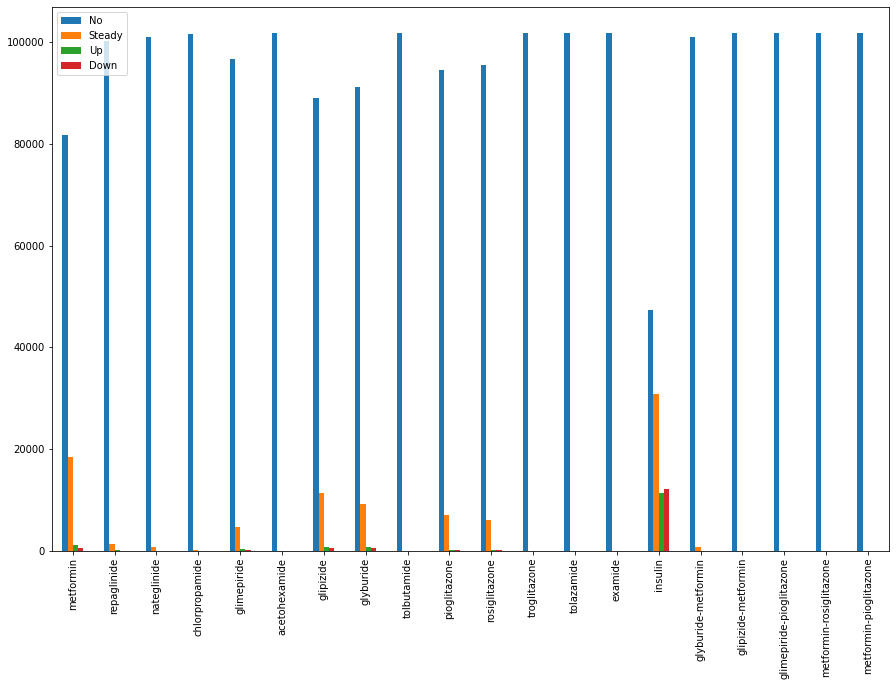

In [39]:
import re
import copy
all_cols = list(df.columns)
meds = pd.DataFrame()
i=0

#dummy = pd.DataFrame()
idx =  ['No','Steady', 'Up', 'Down']
cols = list()
dx = dict()

for e in all_cols:
    if e.endswith('de') or e.endswith('ne') or e.endswith('min') or e.endswith('lin'):
        ser = df[e].value_counts()
        dx[e] = copy.copy(dict(ser))
        
dummy = pd.DataFrame(dx)
dummy.T.plot.bar(logy=False,figsize=(15, 10))
       
        

### After viewing the plot above, we can see that most of the medicines have "No" as the  count which will not add any learning for modeling. <br> Only Insulin, pioglitazone, rosiglitazone, glipizide, glyburide, metformin have positive counts in other categories like Steady, Up and Down. <br> Only these medicine features will be included into modeling data


# Convert all the medication features, age, race, weight etc to one-hot encoding as below

In [40]:
import re
all_cols = list(df.columns)
meds = pd.DataFrame()
i=0
for e in all_cols:
    if e.endswith('insulin') or \
        e.endswith('race') or e.endswith('gender') or e.endswith('age') or e.endswith('medical_specialty') :
        dummy = pd.get_dummies(df[e], prefix=e)
        frames = [meds, dummy]
        meds = pd.concat(frames, axis=1)
    


In [41]:
len(df['number_outpatient'].unique())

39

In [42]:
df.age.unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [43]:
df['max_glu_serum'].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

### Feature like time_in_hospital, num_lab_procedures, num_procedures, num_medications, <br>number_outpatient, number_emergency, number_inpatient are discrete values and they need to be standardized
       

In [44]:
norm_list=['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient']

norm_df = pd.DataFrame()
for n1 in norm_list:
    norm_df['norm_'+n1]=(df[n1]-df[n1].mean())/df[n1].std()

norm_df

,norm_time_in_hospital,norm_num_lab_procedures,norm_num_procedures,norm_num_medications,norm_number_outpatient,norm_number_emergency,norm_number_inpatient
0,-1.137643,-0.106516,-0.785394,-1.848259,-0.291460,-0.212619,-0.503274
1,-0.467650,0.808380,-0.785394,0.243388,-0.291460,-0.212619,-0.503274
2,-0.802647,-1.631343,2.145770,-0.371802,1.286742,-0.212619,0.288578
3,-0.802647,0.045966,-0.199161,-0.002688,-0.291460,-0.212619,-0.503274
4,-1.137643,0.401759,-0.785394,-0.986992,-0.291460,-0.212619,-0.503274
...,...,...,...,...,...,...,...
101761,-0.467650,0.401759,-0.785394,-0.002688,-0.291460,-0.212619,-0.503274
101762,0.202342,-0.513137,0.973305,0.243388,-0.291460,-0.212619,0.288578
101763,-1.137643,0.503414,-0.785394,-0.863954,0.497641,-0.212619,-0.503274
101764,1.877324,0.096794,0.387072,0.612503,-0.291460,-0.212619,0.288578


### There are many other features in the data which will not be considered now due to compute limitations. <br> The combined data of normalized discrete data and one-hot encoded categorical data will be included into modeling as shown below. 

In [45]:
frames = [meds, norm_df]
combined_df = pd.concat(frames, axis=1)
target = df.readmitted_binary

In [46]:
combined_df

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),medical_specialty_AllergyandImmunology,medical_specialty_Anesthesiology,medical_specialty_Anesthesiology-Pediatric,medical_specialty_Cardiology,medical_specialty_Cardiology-Pediatric,medical_specialty_DCPTEAM,medical_specialty_Dentistry,medical_specialty_Dermatology,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Endocrinology-Metabolism,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Neurophysiology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_Obstetrics,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Ophthalmology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_OutreachServices,medical_specialty_Pathology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-AllergyandImmunology,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-EmergencyMedicine,medical_specialty_Pediatrics-Endocrinology,medical_specialty_Pediatrics-Hematology-Oncology,medical_specialty_Pediatrics-InfectiousDiseases,medical_specialty_Pediatrics-Neurology,medical_specialty_Pediatrics-Pulmonology,medical_specialty_Perinatology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Proctology,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Addictive,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Resident,medical_specialty_Rheumatology,medical_specialty_Speech,medical_specialty_SportsMedicine,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Maxillofacial,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,medical_specialty_Surgery-PlasticwithinHeadandNeck,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,medical_specialty_unknown,insulin_Down,insulin_No,insulin_Steady,insulin_Up,norm_time_in_hospital,norm_num_lab_procedures,norm_num_procedures,norm_num_medications,norm_number_outpatient,norm_number_emergency,norm_number_inpatient
0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1.137643,-0.106516,-0.785394,-1.848259,-0.291460,-0.212619,-0.503274
1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0.467650,0.808380,-0.785394,0.243388,-0.291460,-0.212619,-0.503274
2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,-0.802647,-1.631343,2.145770,-0.371802,1.286742,-0.212619,0.288578
3,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0.8

In [47]:
# Count of readmitted vs not readmitted
Counter(target)

Counter({0: 90409, 1: 11357})

### The Data is imbalanced. There are more number of not readmitted examples than readmitted examples.<br> As seen above, there are only 11357 readmitted cases compared to 90409 not readmitted <br> SMOTE library will be used to rebalance the data

In [48]:
# Using Smote , lets rebalance the data
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(combined_df, target)

In [49]:
Counter(y)

Counter({0: 90409, 1: 90409})

# Modeling Preparations 

Which methods are you proposing to utilize to solve the problem?  Why is this method appropriate given the business objective? How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a binary-classification one (ex., Accuracy, F1-score, Precision, Recall, AUC, etc.)?!


Since we are concered with hospital readmittance, as a binary outcome, we are interested in classification into one class or another.  We will use a decision tree classifer and a random forest classifier.  We believe a decision tree will have the benfits of being a simple model, and we can take advantage of a large part of our dataset, and we would like to be able to run the models on our local machines.

As mentioned above we will also use a random forest classifier.  As an ensemble learning algorithm, it consists of many decision trees, so it is a natrual expansion on our first method.  

Since the problem is a binary-classification one, we will use accuracy, precision, and recall as our metrics.  To speak to the determination of which approach is more or less useful, we will compare the two modeling methods and compare results, we will consider a classifer successful if accuracy is $\geq$ 0.75.  If for some reason the accuracy among the classifers is equal, we will compare on the metrics of precision and recall.

# Model Building and Evaluation

### Explain how you handled missing values
Missing values were handled in a variety of methods, including:
Weight with average value 
Race with primary and secondary (in order of prevalence contained in records) 

### Specify your sampling methodology
The data suffers from heavy class imbalance, so SMOTE was used to fix this imbalance.
For modeling, the data was seperated into testing and training sets with a 70% training, 30% testing split with a random seed set.  


### Analyzing Model Performance

#### As specified above, we will use the metrics of accuracy, precision, and recall

As a reminder:  

Accuracy = $\frac{{\sum TP + TN}}{\sum TP + FP + FN + TN}$


Precision = $\frac{\sum TP}{\sum TP + FP}$


Recall = $\frac{\sum TP}{\sum TP + FN}$

### After rebalance , the readmitted and not readmitted are equal as seen above

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.30, random_state=42)

#### Set up models

##### We will highlight important feautres below after running models. 

In [51]:
params = [
          ('lbfgs', 0.1,'l2'),
          ('lbfgs', 0.01,'l2'),
          ('liblinear', 0.1, 'l1'),
          ('liblinear', 0.01, 'l1')
         ]

saved_coef = dict()

for sol,reg_val,penalty in params:
    print("Solver {} Penalty {} strength {}".format(sol, penalty, reg_val))
    logreg = LogisticRegression(C=reg_val, penalty=penalty, solver=sol, max_iter=500)
    logreg.fit(X_train, y_train)
    print('coeff vals {}'.format(logreg.coef_[0:5]))
    saved_coef[(sol,reg_val,penalty)] = copy.deepcopy(logreg.coef_)
    scores = cross_val_score(logreg, X, y, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print('-'*30)
    

Solver lbfgs Penalty l2 strength 0.1
coeff vals [[-3.1596439  -3.5704631  -2.90572105 -3.85778608 -3.91273513 -3.46835895
  -3.46935733 -0.16171464 -3.66135745 -4.87766903 -3.84521175 -3.97129435
  -3.78498444 -3.65041351 -3.3145685  -3.18791847 -3.21246137 -3.62694207
  -0.1663842  -0.27262395 -0.567432   -3.1829461  -0.23205793 -0.14959322
  -0.21213668 -0.08337814 -2.88553401 -2.53278718 -0.43554928 -2.71319228
  -3.34759614 -1.75782088 -1.55373639 -2.36040897 -1.5716074  -1.15992675
  -2.61946522 -2.8606151  -2.76505383 -0.08794816 -1.09074187 -0.81829839
  -2.93562951 -2.67146209 -1.38363987 -2.72402814 -3.48690807 -1.43839917
  -2.47514751 -0.53582418 -0.87081096 -2.87921271 -0.13968564 -1.7183464
  -0.11258316 -2.32744942 -0.02720234 -0.05084534 -0.46025986 -0.61949663
  -0.07052456 -2.63222305 -0.62853219 -1.90580928 -0.0839089  -2.96177858
  -0.08903302 -0.3875144  -2.11593811 -3.43085791 -3.19258264 -1.36748969
  -0.0667409  -0.7792115   0.          0.         -1.36306749 -2.

In [52]:
import collections
dx = dict(zip( list(X.columns), list(saved_coef[('lbfgs',0.1,'l2')][0]) ))


In [53]:
sorted_values = sorted(dx.values()) # Sort the values
sorted_dict = {}

for i in sorted_values:
    for k in dx.keys():
        if dx[k] == i:
            sorted_dict[k] = dx[k]
            break

sorted_dict

{'age_[10-20)': -4.8776690311209,
 'age_[30-40)': -3.971294346584478,
 'insulin_Up': -3.951306621799026,
 'race_Other': -3.9127351291441523,
 'race_Hispanic': -3.857786083957391,
 'age_[20-30)': -3.845211749109124,
 'age_[40-50)': -3.784984441131224,
 'insulin_Steady': -3.7819283817087683,
 'insulin_No': -3.7756645474661323,
 'insulin_Down': -3.7685165753577055,
 'age_[0-10)': -3.661357445294717,
 'age_[50-60)': -3.650413505078534,
 'age_[90-100)': -3.6269420719904204,
 'race_Asian': -3.570463100820625,
 'medical_specialty_Orthopedics-Reconstructive': -3.486908071370385,
 'gender_Male': -3.469357328174194,
 'gender_Female': -3.4683589468638667,
 'medical_specialty_Pulmonology': -3.430857914771483,
 'medical_specialty_Surgery-Cardiovascular/Thoracic': -3.3919970756743067,
 'medical_specialty_Gastroenterology': -3.3475961404352446,
 'age_[60-70)': -3.3145684988232924,
 'medical_specialty_Surgery-Neuro': -3.21623311228461,
 'age_[80-90)': -3.212461365932602,
 'medical_specialty_Radiologis

# Model Interpretability & Explainability

### Top 5 Features from Decision Tree and Random Forest

1)Norm time in hospital

2)Norm number inpatient

3)Norm number medications

4)Norm num lab procedures

5)Norm num procedures

*order is different between algorithms, but the features are consistent between the two.

This output is the sorted feature importance by the algorithms.  These variables are considered most useful based on how useful they are at predicting a target variable. 

On the opposite side, below are some of the least significant features.  These features can be considered the least useful based on theur ability to predict our target variable:

1. Age 0-10
2. Age 30-40
3. insulin_Up


To interpret feature importance, the audience needs to consider the "important" features as the ones that are "best" at predicting the target variable of hospital readmission.  


In [54]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=28, min_samples_split=10)

In [55]:
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,7664,6610,14274
1,983,892,1875
All,8647,7502,16149


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.88
Precision is 0.90
Recall is 0.85


                       Feature  Importance
15                 age_[70-80)    0.006749
90   medical_specialty_unknown    0.008393
93              insulin_Steady    0.008486
100      norm_number_emergency    0.012580
99      norm_number_outpatient    0.022373
97         norm_num_procedures    0.067289
96     norm_num_lab_procedures    0.075359
98        norm_num_medications    0.109923
101      norm_number_inpatient    0.205017
95       norm_time_in_hospital    0.386212


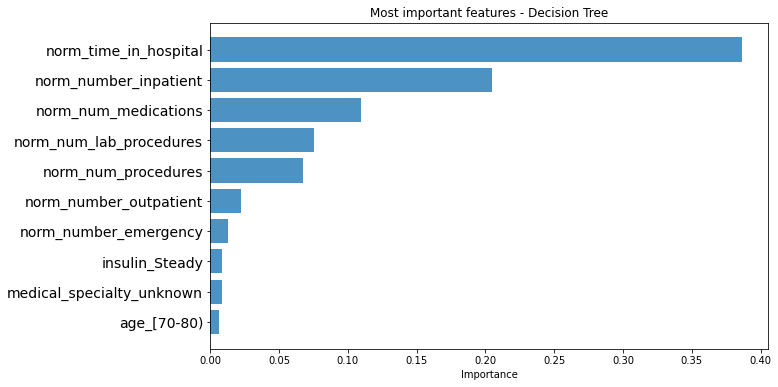

In [57]:
import matplotlib.pyplot as plt
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

In [58]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=10)

In [59]:
rm_prd = rm.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,8075,6199,14274
1,1031,844,1875
All,9106,7043,16149


In [60]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.2f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.2f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.87
Precision is 0.92
Recall is 0.81


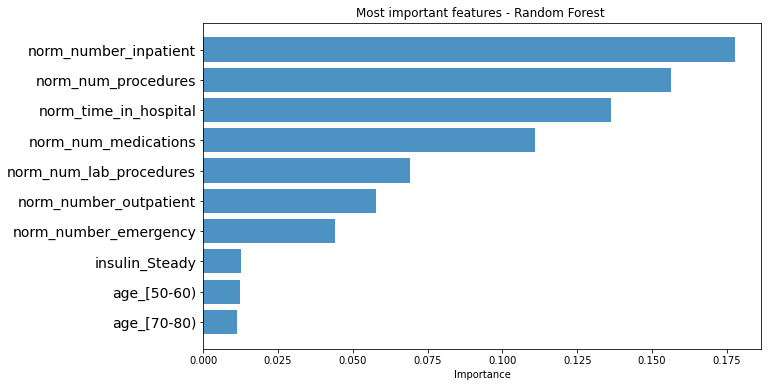

In [61]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

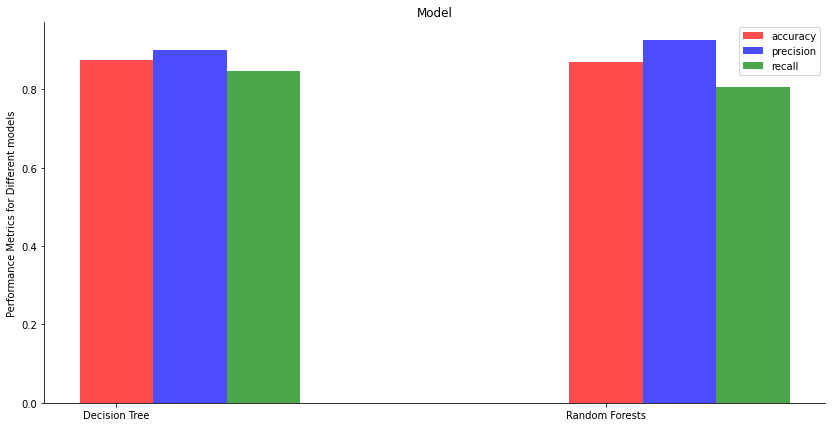

In [62]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Decision Tree', 'Random Forests']
values = [accuracy_dtree, accuracy_rm]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)
           

           
ax = plt.subplot(111)

models = ['Decision Tree', 'Random Forests']
values = [precision_dtree, precision_rm]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Decision Tree', 'Random Forests' ]
values = [recall_dtree, recall_rm, ]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()   

# Case Conclusions

What are we proposing to our audience and why?

Our primary takeaway is that in general patients who spend more time in hospitals are more prone to being readmitted.  Patients that have been in the hopsital in the last year, they are more likely to be readmitted. In addition to this, number of prescriptions is also a strong indicator of being readmitted to the hospital.   

How should they view our results and what to consider moving forward?

We believe that these results are reasonable and intuitive given the data in the above analysis, we believe that the medical community should keep a close eye on patients that often visit the hospital for both caregiving and financial reasons.  

Are there any other approaches we recommend exploring?

As an additional step, we believe there is great benefit to doing a cluster analysis to determine if there are any natural clusters that appear in the data surrounding our outcome of interest.  These topics could be explored in more detail should such clusters appear. 


